Action1	股票价格预测
任何股票价格预测，比如 美吉姆
http://quotes.money.163.com/trade/lsjysj_002621.html
历史数据（从1990年12月19日至今）
请你编写代码对该股票未来3个月的变化进行预测（可以按照月来统计，也可以按照天）
模型选择：ARMA/ARIMA/LSTM 中的任意一种"	
1、完成代码（30points）
2、结果正确（30points）

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

In [24]:
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
# 数据加载
df = pd.read_csv('./meijimu_19901219.csv',encoding="gbk")
print(df)

              日期     股票代码    名称    收盘价    最高价    最低价    开盘价    前收盘    涨跌额  \
0     2020-10-16  '002621   美吉姆   7.07   7.19   6.97   7.00   7.04   0.03   
1     2020-10-15  '002621   美吉姆   7.04   7.23   6.90   7.02   6.85   0.19   
2     2020-10-14  '002621   美吉姆   6.85   7.16   6.84   6.93   6.95   -0.1   
3     2020-10-13  '002621   美吉姆   6.95   6.96   6.84   6.95   6.96  -0.01   
4     2020-10-12  '002621   美吉姆   6.96   6.99   6.72   6.99   6.86    0.1   
...          ...      ...   ...    ...    ...    ...    ...    ...    ...   
2192  2011-10-11  '002621  大连三垒  24.13  25.85  23.70  24.25  23.60   0.53   
2193  2011-10-10  '002621  大连三垒  23.60  24.18  22.36  22.66  22.69   0.91   
2194  2011-09-30  '002621  大连三垒  22.69  23.80  22.05  23.10  24.08  -1.39   
2195  2011-09-29  '002621   N三垒  24.08  25.15  22.88  23.98  24.00   0.08   
2196  2011-09-20  '002621  大连三垒   0.00   0.00   0.00   0.00  24.00   None   

          涨跌幅      换手率       成交量          成交金额           总市值          流通市值 

In [25]:
df.rename(columns={'日期':'Timestamp','成交金额':'Price'}, inplace=True)
print(df)

       Timestamp     股票代码    名称    收盘价    最高价    最低价    开盘价    前收盘    涨跌额  \
0     2020-10-16  '002621   美吉姆   7.07   7.19   6.97   7.00   7.04   0.03   
1     2020-10-15  '002621   美吉姆   7.04   7.23   6.90   7.02   6.85   0.19   
2     2020-10-14  '002621   美吉姆   6.85   7.16   6.84   6.93   6.95   -0.1   
3     2020-10-13  '002621   美吉姆   6.95   6.96   6.84   6.95   6.96  -0.01   
4     2020-10-12  '002621   美吉姆   6.96   6.99   6.72   6.99   6.86    0.1   
...          ...      ...   ...    ...    ...    ...    ...    ...    ...   
2192  2011-10-11  '002621  大连三垒  24.13  25.85  23.70  24.25  23.60   0.53   
2193  2011-10-10  '002621  大连三垒  23.60  24.18  22.36  22.66  22.69   0.91   
2194  2011-09-30  '002621  大连三垒  22.69  23.80  22.05  23.10  24.08  -1.39   
2195  2011-09-29  '002621   N三垒  24.08  25.15  22.88  23.98  24.00   0.08   
2196  2011-09-20  '002621  大连三垒   0.00   0.00   0.00   0.00  24.00   None   

          涨跌幅      换手率       成交量         Price           总市值          流通市值 

In [26]:
df = df[['Timestamp', 'Price']]

In [27]:
# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp
# 数据探索
print(df.head())
# 按照月，季度，年来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
print(df_month)

# 设置参数范围
ps = range(0, 5)
qs = range(0, 5)
ds = range(1, 2)
parameters = product(ps, ds, qs)
parameters_list = list(parameters)

            Timestamp        Price
Timestamp                         
2020-10-16 2020-10-16  33027211.88
2020-10-15 2020-10-15  44353038.57
2020-10-14 2020-10-14  22796468.55
2020-10-13 2020-10-13  12754077.98
2020-10-12 2020-10-12  28129606.84
                   Price
Timestamp               
2011-09-30  1.340575e+08
2011-10-31  1.383319e+08
2011-11-30  8.421548e+07
2011-12-31  3.984084e+07
2012-01-31  2.287566e+07
...                  ...
2020-06-30  1.990633e+07
2020-07-31  5.716959e+07
2020-08-31  6.381929e+07
2020-09-30  2.321895e+07
2020-10-31  2.994964e+07

[110 rows x 1 columns]


In [28]:
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        #model = ARIMA(df_month.Price,order=(param[0], param[1], param[2])).fit()
        # SARIMAX 包含季节趋势因素的ARIMA模型
        model = sm.tsa.statespace.SARIMAX(df_month.Price,
                                order=(param[0], param[1], param[2]),
                                #seasonal_order=(4, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

最优模型:                                 SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  110
Model:               SARIMAX(0, 1, 4)   Log Likelihood               -1924.646
Date:                Tue, 20 Oct 2020   AIC                           3859.293
Time:                        16:33:43   BIC                           3872.515
Sample:                    09-30-2011   HQIC                          3864.649
                         - 10-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4723      0.080     -5.915      0.000      -0.629      -0.316
ma.L2         -0.0574      0.083     -0.694      0.488      -0.219       0.105
ma.L3         -0.1328      0.113     -1.174  

In [29]:
# 设置future_month，需要预测的时间date_list
df_month2 = df_month[['Price']]
future_month = 3
last_month = pd.to_datetime(df_month2.index[len(df_month2)-1])
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:
        month = 1
        year = year+1
    else:
        month = month + 1
    next_month_days = calendar.monthrange(year, month)[1]
    #print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=', date_list)

date_list= [Timestamp('2020-11-30 00:00:00', freq='M'), Timestamp('2020-12-31 00:00:00', freq='M'), Timestamp('2021-01-31 00:00:00', freq='M')]


In [30]:
# 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])

# get_prediction得到的是区间，使用predicted_mean
df_month2['forecast'] = best_model.get_prediction(start=0, end=len(df_month2)).predicted_mean


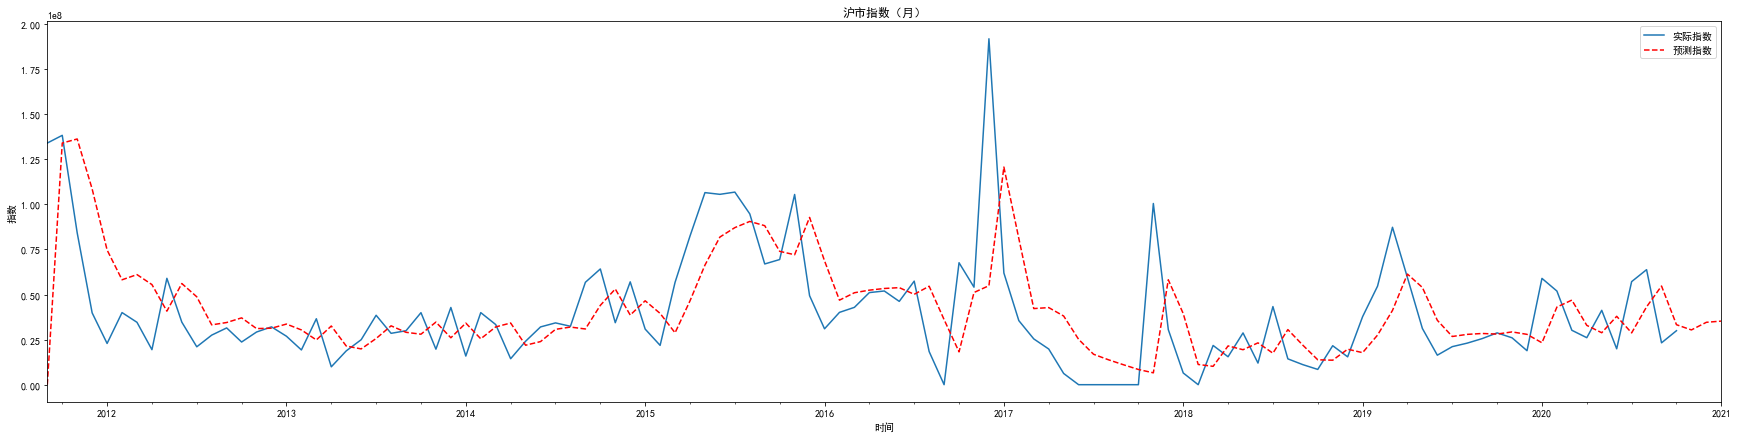

In [31]:
# 股票指数预测结果显示
plt.figure(figsize=(30,7))
df_month2.Price.plot(label='实际指数')
df_month2.forecast.plot(color='r', ls='--', label='预测指数')
plt.legend()
plt.title('沪市指数（月）')
plt.xlabel('时间')
plt.ylabel('指数')
plt.show()